In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)



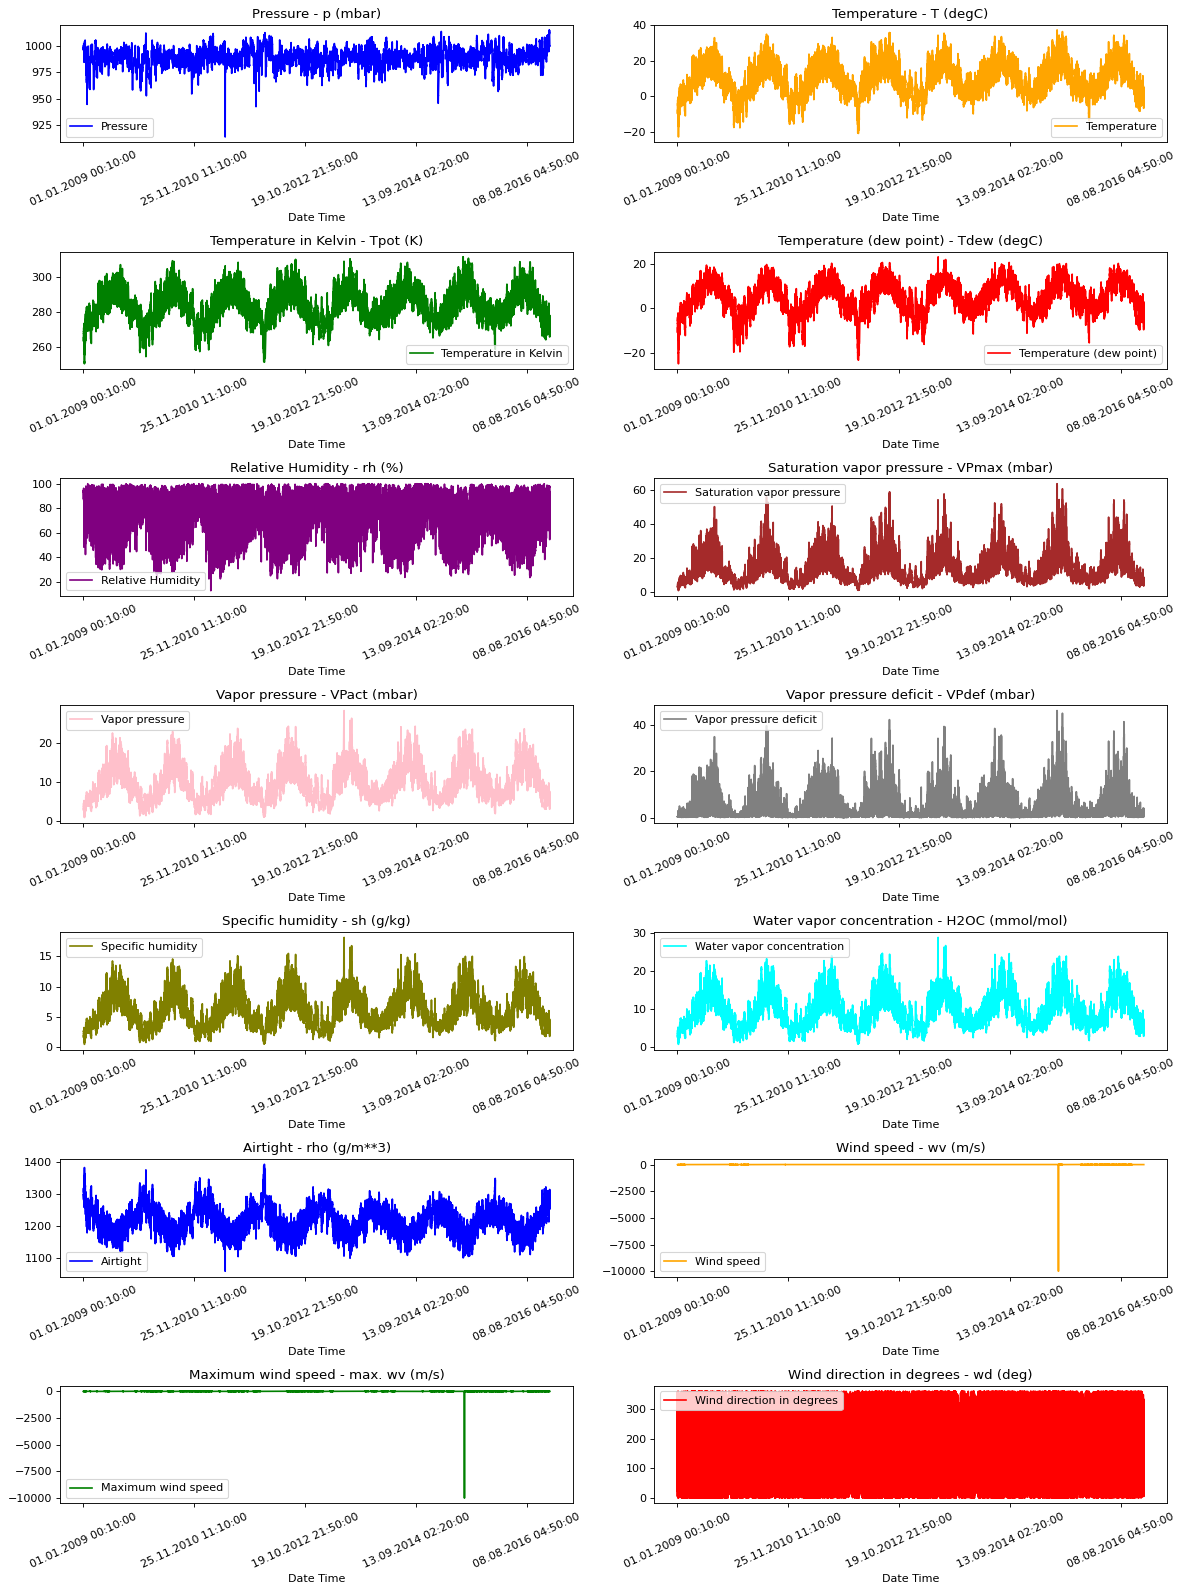

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)


In [4]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 3


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [5]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]


The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [6]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)


In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


In [8]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (256, 120, 7)
Target shape: (256, 1)


In [9]:
for x, y in dataset_val:
    print(x, y)

tf.Tensor(
[[[-1.09200151e-01  8.55794169e-01  7.17157085e-01 ...  1.38484700e+00
   -8.79576612e-01 -9.42550885e-01]
  [-1.04338730e-01  6.56605184e-01  4.59283771e-01 ...  1.38856578e+00
   -7.06029721e-01 -1.01458496e+00]
  [-1.27430482e-01  6.03333712e-01  3.94164247e-01 ...  1.31419017e+00
   -6.61725085e-01 -8.50871155e-01]
  ...
  [ 1.43593763e-01  1.73475120e-02 -2.15354494e-01 ...  2.58056483e-01
   -2.23675679e-02 -8.11579843e-01]
  [ 2.17730439e-01 -4.65592233e-03 -2.34890351e-01 ...  2.91525508e-01
    1.43489817e-02 -7.81420086e-02]
  [ 2.05576886e-01 -3.49784684e-03 -2.33587961e-01 ...  3.17556972e-01
    8.96388777e-03 -1.30530425e-01]]

 [[-1.10415507e-01  8.52319943e-01  7.11947523e-01 ...  1.38112822e+00
   -8.76639288e-01 -1.30272125e+00]
  [-1.07984796e-01  6.55447109e-01  4.57981381e-01 ...  1.38856578e+00
   -7.06029721e-01 -1.16520166e+00]
  [-1.24999771e-01  5.66275296e-01  3.49882971e-01 ...  1.29931504e+00
   -6.27945859e-01 -1.16520166e+00]
  ...
  [ 1.569626

tf.Tensor(
[[[-0.45800714  1.08277697  1.0427547  ...  1.47037895 -1.16107016
   -0.22221015]
  [-0.46286856  0.96581134  0.86953677 ...  1.57822359 -1.06781012
   -1.05387627]
  [-0.39237795  1.02487319  0.95549454 ...  1.28443992 -1.08763706
   -0.72644867]
  ...
  [-0.74361565  0.90443334  0.783579   ...  1.0204065  -1.05679516
   -0.53654065]
  [-0.77156882  0.69018937  0.50096027 ...  1.07246943 -0.88177961
   -1.20449297]
  [-0.76549204  0.56395914  0.34727819 ...  1.0204065  -0.76820308
   -0.62822038]]

 [[-0.44949965  1.06077353  1.00889255 ...  1.48153529 -1.14099845
   -0.59547762]
  [-0.45193036  0.98897285  0.90339892 ...  1.42575358 -1.07784598
   -0.32698699]
  [-0.37414762  1.01213436  0.93726107 ...  1.25468968 -1.07099222
    0.28202836]
  ...
  [-0.74969242  0.87432338  0.7419025  ...  1.06875065 -1.03501001
   -0.81812839]
  [-0.77399953  0.67397632  0.48142441 ...  1.05387553 -0.86758254
   -1.23068718]
  [-0.76549204  0.54195571  0.32253277 ...  1.00925016 -0.7486

tf.Tensor(
[[[-0.87487403  0.31034061  0.06726424 ...  0.8865304  -0.56601728
   -0.92945378]
  [-0.88216616  0.28023065  0.03600687 ...  0.89396796 -0.5412948
   -0.98839075]
  [-0.85785905  0.29760178  0.05424033 ...  0.84562381 -0.54839333
   -0.80503129]
  ...
  [ 0.0961949   0.78515156  0.62338497 ...  1.58566115 -0.77848371
   -0.79848274]
  [ 0.07310315  0.71914126  0.5374272  ...  1.23609577 -0.71043571
   -0.94255088]
  [ 0.07067244  0.61259832  0.40588576 ...  0.97206235 -0.60567115
    0.32131967]]

 [[-0.88338151  0.2871791   0.04382121 ...  0.83446747 -0.54521123
   -0.30734133]
  [-0.86758189  0.29644371  0.05293794 ...  0.90884308 -0.55279932
   -1.11281324]
  [-0.8347673   0.29412755  0.05033316 ...  0.86049894 -0.54056047
   -0.87051681]
  ...
  [ 0.09984097  0.76893851  0.60124433 ...  1.58194237 -0.76330754
   -0.98839075]
  [ 0.0718878   0.70408628  0.51789134 ...  1.2509709  -0.69844163
   -0.81157984]
  [ 0.06581102  0.59870141  0.38895469 ...  0.81587357 -0.58706

tf.Tensor(
[[[-1.31726338  0.5801722   0.36681405 ...  0.43655795 -0.88887814
    0.2492856 ]
  [-1.3464319   0.41456741  0.17796743 ...  0.40308893 -0.75008958
    0.13796021]
  [-1.43515284  0.2918114   0.04772838 ...  0.33615088 -0.66074598
    0.77971832]
  ...
  [-0.11041551  0.25243684  0.00735428 ... -0.05432109 -0.28183118
   -0.90325957]
  [-0.14444546  0.1030451  -0.13721107 ... -0.11754036 -0.15283371
    0.77971832]
  [-0.09340053 -0.06950815 -0.29219553 ... -0.14357182  0.01753108
   -0.92945378]]

 [[-1.32820157  0.55816877  0.34076624 ...  0.42912039 -0.8722333
    0.06592614]
  [-1.35372404  0.39951242  0.16233874 ...  0.40308893 -0.73858506
    0.10521745]
  [-1.45459853  0.27907257  0.03470448 ...  0.32499453 -0.65364744
    0.63565017]
  ...
  [-0.11284622  0.20032344 -0.04343895 ... -0.08407133 -0.23434445
   -0.47105513]
  [-0.15052223  0.04514132 -0.19060908 ... -0.12497792 -0.10192009
    1.30360248]
  [-0.09340053 -0.11467309 -0.32996486 ... -0.1472906   0.05889

tf.Tensor(
[[[-0.32674876 -0.96238436 -0.90171427 ... -0.70138891  0.82407129
   -1.05387627]
  [-0.37900904 -1.00870738 -0.92645969 ... -0.74229549  0.85736096
   -1.11281324]
  [-0.38387046 -1.0121816  -0.92776208 ... -0.74229549  0.8590744
   -0.87051681]
  ...
  [-0.00467959 -0.1193054  -0.33387203 ...  0.19111843  0.06868948
   -1.10626469]
  [-0.0399249  -0.1332023  -0.34559354 ...  0.19483721  0.07260591
   -1.06042482]
  [-0.04357096 -0.12857    -0.34168637 ...  0.20599355  0.06697604
   -1.23723573]]

 [[-0.34133302 -0.95427783 -0.8978071  ... -0.69023256  0.81158766
   -0.90325957]
  [-0.38508582 -1.00175892 -0.92255252 ... -0.73485793  0.84879377
   -0.98839075]
  [-0.38265511 -1.01565583 -0.92906447 ... -0.74601427  0.86274605
   -0.92945378]
  ...
  [-0.00467959 -0.11467309 -0.32996486 ...  0.19483721  0.06428349
   -1.19139586]
  [-0.02290992 -0.13436038 -0.34689593 ...  0.20227477  0.07750145
   -0.83777405]
  [-0.05572452 -0.12162155 -0.33517442 ...  0.21343112  0.05718

tf.Tensor(
[[[-0.22952033 -1.3572881  -1.09056089 ... -1.25176843  1.26173256
    0.39335374]
  [-0.23559711 -1.33875889 -1.08274655 ... -1.24804965  1.24166085
    0.00698917]
  [-0.19184432 -1.34107504 -1.08404894 ... -1.25176843  1.25610269
    0.64874727]
  ...
  [ 0.93600545 -0.74003386 -0.7753824  ... -0.54148134  0.9229612
   -1.25033283]
  [ 0.8776684  -0.7713019  -0.79491825 ... -0.57123159  0.94034036
   -1.18484731]
  [ 0.83634632 -0.78751496 -0.80403499 ... -0.57866915  0.94474635
   -0.92290523]]

 [[-0.23802782 -1.35033965 -1.08665372 ... -1.24433087  1.25218626
    0.46538782]
  [-0.22708962 -1.33412659 -1.08014177 ... -1.24804965  1.23921308
    0.13141166]
  [-0.18576754 -1.33991697 -1.08274655 ... -1.25176843  1.25634747
    0.46538782]
  ...
  [ 0.92749797 -0.74582424 -0.77928957 ... -0.56379402  0.92810151
   -1.21104152]
  [ 0.86308413 -0.77477613 -0.79622065 ... -0.57123159  0.93936125
   -1.08661903]
  [ 0.84849987 -0.7666696  -0.79231347 ... -0.54520012  0.92638

tf.Tensor(
[[[ 0.55802994 -0.55010948 -0.65556247 ... -0.69767013  0.65444083
   -0.73299722]
  [ 0.48875468 -0.55358371 -0.65816726 ... -0.80179598  0.6451393
    0.4129994 ]
  [ 0.4474326  -0.57327099 -0.67119116 ... -0.79063964  0.65346172
    0.54397044]
  ...
  [-1.29174091 -0.2374291  -0.42894653 ... -0.44107427 -0.11293506
    3.96886318]
  [-1.47525957 -0.19689645 -0.39768916 ... -0.45594939 -0.19493535
    3.79205228]
  [-1.6296097  -0.15983804 -0.36773418 ... -0.45966817 -0.26689979
    6.35253615]]

 [[ 0.55559923 -0.55358371 -0.65816726 ... -0.73113915  0.65811248
   -0.516895  ]
  [ 0.48146255 -0.55474178 -0.65816726 ... -0.7980772   0.6441602
    0.23618849]
  [ 0.42920227 -0.57674522 -0.67379594 ... -0.8166711   0.65321694
    0.72078135]
  ...
  [-1.32090944 -0.22584834 -0.4198298  ... -0.44107427 -0.13080378
    3.58904716]
  [-1.4934899  -0.189948   -0.39117721 ... -0.45223061 -0.20595032
    4.21770816]
  [-1.60165653 -0.15173151 -0.36122223 ... -0.45223061 -0.267389

   -1.02768206]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[-0.75508884]
 [-0.74929846]
 [-0.74582424]
 [-0.75508884]
 [-0.76087922]
 [-0.77477613]
 [-0.78288265]
 [-0.77940843]
 [-0.78404073]
 [-0.77940843]
 [-0.77940843]
 [-0.7713019 ]
 [-0.76319537]
 [-0.76203729]
 [-0.75508884]
 [-0.75508884]
 [-0.75972114]
 [-0.76782767]
 [-0.77245997]
 [-0.78288265]
 [-0.7851988 ]
 [-0.79330533]
 [-0.80025379]
 [-0.80720224]
 [-0.80836031]
 [-0.81183454]
 [-0.81415069]
 [-0.81415069]
 [-0.81762492]
 [-0.80836031]
 [-0.80256994]
 [-0.80141186]
 [-0.78751496]
 [-0.77825035]
 [-0.77477613]
 [-0.77014382]
 [-0.75972114]
 [-0.74698231]
 [-0.73540156]
 [-0.71803043]
 [-0.71339812]
 [-0.74466616]
 [-0.77014382]
 [-0.77709228]
 [-0.76087922]
 [-0.73540156]
 [-0.74929846]
 [-0.75393077]
 [-0.7145562 ]
 [-0.70413352]
 [-0.73771771]
 [-0.74235001]
 [-0.77245997]
 [-0.80025379]
 [-0.80720224]
 [-0.78983111]
 [-0.79793764]
 [-0.81530877]
 [-0.81067647]
 [-0.82457337]
 [-0.82688952]
 [-0.8234153 ]
 [-0

    1.12679158]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[ 0.71450896]
 [ 0.71798319]
 [ 0.74461892]
 [ 0.75156737]
 [ 0.75851583]
 [ 0.77588696]
 [ 0.74461892]
 [ 0.7504093 ]
 [ 0.75851583]
 [ 0.71798319]
 [ 0.66934401]
 [ 0.64502443]
 [ 0.6276533 ]
 [ 0.61259832]
 [ 0.59985949]
 [ 0.59638526]
 [ 0.60217564]
 [ 0.59059488]
 [ 0.57669798]
 [ 0.56974952]
 [ 0.55816877]
 [ 0.53848148]
 [ 0.5141619 ]
 [ 0.49563269]
 [ 0.47594541]
 [ 0.4481516 ]
 [ 0.42730624]
 [ 0.41225126]
 [ 0.40414473]
 [ 0.39951242]
 [ 0.39719627]
 [ 0.40182858]
 [ 0.40298665]
 [ 0.4006705 ]
 [ 0.39256397]
 [ 0.38793167]
 [ 0.39719627]
 [ 0.07872551]
 [-0.23627102]
 [-0.30228132]
 [-0.3601851 ]
 [-0.40882427]
 [-0.4215631 ]
 [-0.44009231]
 [-0.44704076]
 [-0.43893423]
 [-0.42040502]
 [-0.40882427]
 [-0.40187582]
 [-0.39608544]
 [-0.38450468]
 [-0.38566276]
 [-0.39724351]
 [-0.40303389]
 [-0.40998234]
 [-0.42272118]
 [-0.42966963]
 [-0.43430193]
 [-0.43777616]
 [-0.44704076]
 [-0.45977959]
 [-0.4736765 ]
 [-0

tf.Tensor(
[[[ 1.02958782 -1.08861458 -0.9668338  ... -0.83154623  1.29967299
   -0.94909944]
  [ 0.98705038 -1.0689273  -0.95641467 ... -0.82782745  1.26956542
   -0.51034645]
  [ 0.90805228 -1.00986545 -0.92645969 ... -0.78692086  1.1900129
   -0.56273486]
  ...
  [-4.3410675  -1.27738089 -1.05539635 ... -1.23689331  0.12180608
    0.4129994 ]
  [-4.33863679 -1.23684825 -1.03716288 ... -1.18854916  0.08141788
   -0.15672463]
  [-4.34957499 -1.26464206 -1.05018679 ... -1.10673599  0.10075526
   -0.15017608]]

 [[ 1.02715711 -1.09556304 -0.96943858 ... -0.84642135  1.30677153
   -0.79193419]
  [ 0.9809736  -1.05850462 -0.95120511 ... -0.8166711   1.25732657
   -0.9949393 ]
  [ 0.89589873 -1.00407507 -0.92385491 ... -0.78320208  1.18120093
   -0.62167183]
  ...
  [-4.3410675  -1.28664549 -1.05930352 ... -1.23317453  0.13037328
    0.54397044]
  [-4.33985215 -1.26000976 -1.04758201 ... -1.17367404  0.10197915
   -0.12398187]
  [-4.35686712 -1.26811629 -1.05148918 ... -1.08442331  0.10124

tf.Tensor(
[[[-3.83791038e+00 -8.21099145e-01 -8.23570845e-01 ... -9.91453791e-01
   -1.90774142e-01  2.00862728e-02]
  [-3.76134300e+00 -9.26484015e-01 -8.82178416e-01 ... -1.04723550e+00
   -6.96095283e-02 -4.51409478e-01]
  [-3.67505277e+00 -9.77439337e-01 -9.09528616e-01 ... -1.03979794e+00
   -9.28611281e-05 -8.46905607e-02]
  ...
  [ 7.17241491e-01 -1.26000976e+00 -1.04758201e+00 ... -1.22573697e+00
    1.40859876e+00  9.69626326e-01]
  [ 7.36687176e-01 -1.25074515e+00 -1.04367484e+00 ... -1.23317453e+00
    1.40541666e+00  1.38873366e+00]
  [ 7.63424994e-01 -1.24032247e+00 -1.03846527e+00 ... -1.28151868e+00
    1.40443755e+00  1.75545258e+00]]

 [[-3.82454147e+00 -8.33837976e-01 -8.31385188e-01 ... -1.00632891e+00
   -1.74618860e-01  4.71936367e-01]
  [-3.74432802e+00 -9.31116317e-01 -8.84783197e-01 ... -1.04351672e+00
   -6.12871104e-02 -4.31763822e-01]
  [-3.65925315e+00 -1.01565583e+00 -9.29064474e-01 ... -1.04351672e+00
    3.90714584e-02 -3.88506960e-02]
  ...
  [ 7.403332

tf.Tensor(
[[[ 3.38050620e-01 -2.57116380e-01 -4.44575217e-01 ... -8.35265007e-01
    3.31335193e-01  8.38655284e-01]
  [ 3.31973843e-01 -2.45535625e-01 -4.35458484e-01 ... -9.09640618e-01
    3.22767998e-01  7.40427003e-01]
  [ 3.39265975e-01 -1.80683397e-01 -3.84665256e-01 ... -9.80297449e-01
    2.67937951e-01  3.73708086e-01]
  ...
  [-1.56641122e+00 -3.99559666e-01 -5.51371236e-01 ... -1.04351672e+00
   -3.03018509e-03  1.24466551e+00]
  [-1.45945995e+00 -3.47446268e-01 -5.13601913e-01 ... -1.05839184e+00
   -2.35914529e-02  7.20781347e-01]
  [-1.40355361e+00 -2.94174796e-01 -4.73227808e-01 ... -9.91453791e-01
   -6.20214414e-02  4.65387815e-01]]

 [[ 3.31973843e-01 -2.11951436e-01 -4.09410675e-01 ... -8.31546226e-01
    2.87764888e-01  4.91582023e-01]
  [ 3.25897066e-01 -2.24690266e-01 -4.19829798e-01 ... -8.98484276e-01
    3.01472399e-01  4.06450846e-01]
  [ 3.47773462e-01 -2.06161058e-01 -4.04201113e-01 ... -9.80297449e-01
    2.93639536e-01  3.27868221e-01]
  ...
  [-1.542104

tf.Tensor(
[[[-5.33359171e-01 -1.00407507e+00 -9.23854912e-01 ... -1.02120404e+00
    8.27742944e-01  4.26096502e-01]
  [-6.88924656e-01 -9.42697072e-01 -8.91295150e-01 ... -9.91453791e-01
    7.27139598e-01  1.27085972e+00]
  [-7.76430242e-01 -8.04886088e-01 -8.14454112e-01 ... -9.61703546e-01
    5.71216650e-01  9.69626326e-01]
  ...
  [ 2.42724648e+00 -6.48545897e-01 -7.19379607e-01 ... -8.35265007e-01
    1.22746378e+00  1.70702971e-01]
  [ 2.43940003e+00 -6.54336274e-01 -7.23286779e-01 ... -8.50140129e-01
    1.23676531e+00  3.14771117e-01]
  [ 2.41630828e+00 -6.54336274e-01 -7.23286779e-01 ... -8.05514762e-01
    1.22844289e+00  1.96897179e-01]]

 [[-5.63743055e-01 -9.93652394e-01 -9.18645350e-01 ... -1.01748525e+00
    8.08650338e-01  6.22553065e-01]
  [-7.12016408e-01 -8.97532128e-01 -8.66549731e-01 ... -9.80297449e-01
    6.77694644e-01  2.10252584e+00]
  [-7.81291663e-01 -7.90989182e-01 -8.06639769e-01 ... -9.57984766e-01
    5.57019585e-01  5.76713201e-01]
  ...
  [ 2.430892

tf.Tensor(
[[[-1.53967341 -0.09614389 -0.31433617 ... -0.34066719 -0.30777755
   -1.15210455]
  [-1.53967341 -0.10772464 -0.32475529 ... -0.32951085 -0.29798647
   -1.16520166]
  [-1.47404422 -0.12277962 -0.33647681 ... -0.2997606  -0.26934756
   -0.87706536]
  ...
  [-0.78250702 -0.63117476 -0.70896048 ... -0.92823452  0.40378918
    0.11831455]
  [-0.75941527 -0.69718507 -0.74933459 ... -0.97285989  0.47404018
   -0.63476894]
  [-0.81775232 -0.67286548 -0.73500829 ... -1.01004769  0.43854752
   -0.18291884]]

 [[-1.53238127 -0.12509577 -0.33908159 ... -0.35182353 -0.27938341
   -1.15210455]
  [-1.52387379 -0.19110608 -0.3924796  ... -0.34810475 -0.21745483
   -1.04077917]
  [-1.46553673 -0.14015076 -0.3508031  ... -0.26629158 -0.25319228
   -0.43176382]
  ...
  [-0.77886095 -0.61959401 -0.70114614 ... -0.93939086  0.39424288
    0.32786822]
  [-0.74969242 -0.70297544 -0.75324176 ... -0.98401623  0.48285215
   -0.38592396]
  [-0.83233659 -0.67865586 -0.73891546 ... -1.01004769  0.4405

    0.19689718]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[-0.76551152]
 [-0.75972114]
 [-0.74350809]
 [-0.72266273]
 [-0.70876582]
 [-0.69602699]
 [-0.67402356]
 [-0.67518163]
 [-0.84889296]
 [-0.9600682 ]
 [-1.00175892]
 [-1.02492043]
 [-1.01102353]
 [-1.0075493 ]
 [-1.00523315]
 [-1.00870738]
 [-0.99712662]
 [-0.99944277]
 [-0.9982847 ]
 [-0.99133624]
 [-0.98322971]
 [-0.98670394]
 [-0.97975549]
 [-0.97512319]
 [-0.9508036 ]
 [-0.91721941]
 [-0.87321254]
 [-0.83847028]
 [-0.80025379]
 [-0.78172458]
 [-0.77940843]
 [-0.77940843]
 [-0.77825035]
 [-0.78404073]
 [-0.79909571]
 [-0.72845311]
 [-0.66360088]
 [-0.62422631]
 [-0.65433627]
 [-0.6485459 ]
 [-0.60453903]
 [-0.55705793]
 [-0.51073491]
 [-0.49915416]
 [-0.55937408]
 [-0.61032941]
 [-0.6010648 ]
 [-0.58369367]
 [-0.58021944]
 [-0.60917133]
 [-0.63580707]
 [-0.62422631]
 [-0.60222288]
 [-0.62885861]
 [-0.6624428 ]
 [-0.66360088]
 [-0.63696514]
 [-0.63928129]
 [-0.66475895]
 [-0.72613695]
 [-0.72150465]
 [-0.70413352]
 [-0

tf.Tensor(
[[[ 1.19973757  1.30512746  1.39570252 ... -0.73113915 -0.85118248
    0.15760587]
  [ 1.16206155  1.23332678  1.27848738 ... -0.85385891 -0.79317033
   -0.0519478 ]
  [ 1.16449226  1.08161889  1.04014992 ... -0.89104672 -0.6605012
   -0.14362753]
  ...
  [-1.01342454  1.14068074  1.13131726 ...  0.3882138  -1.29251541
    1.06785461]
  [-1.07783837  1.02487319  0.95549454 ...  0.42540161 -1.21198377
    1.66377285]
  [-1.14589827  1.20437489  1.23160132 ...  0.45143307 -1.38063513
    0.91723791]]

 [[ 1.19366079  1.28775633  1.36704993 ... -0.74973305 -0.83674064
    0.75352411]
  [ 1.16935368  1.25648829  1.3162567  ... -0.85757769 -0.81079428
    0.32131967]
  [ 1.17543046  1.03297972  0.96721606 ... -0.8947655  -0.61570701
    0.07902324]
  ...
  [-1.0170706   1.13257421  1.11829335 ...  0.39937014 -1.28713031
    1.56554457]
  [-1.08634586  1.08046081  1.03884753 ...  0.4849021  -1.26363172
    0.97617488]
  [-1.14954434  1.20205874  1.22769415 ...  0.48118332 -1.38087

tf.Tensor(
[[[-0.54308201 -0.04518856 -0.27135728 ... -0.5117311  -0.09824844
   -0.78538563]
  [-0.55645092 -0.02434321 -0.25312382 ... -0.55635646 -0.11832015
   -0.40556961]
  [-0.50662135 -0.0810889  -0.30131227 ... -0.52288744 -0.05614679
   -0.64786604]
  ...
  [ 0.09862561  0.46436465  0.23397022 ...  0.55555893 -0.44852432
   -0.28114712]
  [ 0.04271927  0.40761895  0.17015309 ...  0.57415283 -0.41278688
   -0.61512328]
  [-0.01926386  0.39024782  0.15191962 ...  0.58159039 -0.41278688
   -0.5299921 ]]

 [[-0.54672808 -0.04634664 -0.27135728 ... -0.51916866 -0.09775888
   -0.62822038]
  [-0.56374305 -0.01855283 -0.24791426 ... -0.56007524 -0.12517391
   -0.62167183]
  [-0.49811387 -0.12972808 -0.34298876 ... -0.46338695 -0.01257649
   -0.67406025]
  ...
  [ 0.08647206  0.4527839   0.22094631 ...  0.55555893 -0.44118101
   -0.37282685]
  [ 0.03056571  0.40298665  0.16624591 ...  0.58159039 -0.41205255
   -0.74609432]
  [-0.02777134  0.37635091  0.13629093 ...  0.57787161 -0.4025

tf.Tensor(
[[[ 0.35506559  0.92759485  0.81613876 ...  0.26177526 -0.77677027
   -0.73954577]
  [ 0.41583336  0.8164196   0.66375908 ...  0.06096111 -0.65658477
   -0.98839075]
  [ 0.52278463  0.70640243  0.52179851 ... -0.04688352 -0.52954551
   -0.24185581]
  ...
  [ 0.31617422  0.72145741  0.54003198 ...  0.2543377  -0.60713981
    0.14450876]
  [ 0.28579034  0.74230277  0.56738218 ...  0.14649307 -0.62745631
    0.24273704]
  [ 0.322251    0.69250552  0.50356505 ...  0.03864843 -0.57017849
   -0.0650449 ]]

 [[ 0.35506559  0.90211719  0.78097422 ...  0.2543377  -0.75449557
   -0.79848274]
  [ 0.42920227  0.78630964  0.62468736 ...  0.04236721 -0.62623242
   -1.02768206]
  [ 0.53372283  0.69250552  0.50356505 ... -0.08035255 -0.51314545
   -0.12398187]
  ...
  [ 0.3113128   0.70871858  0.52440329 ...  0.24690014 -0.59685918
    0.66184438]
  [ 0.28822105  0.73188009  0.55435828 ...  0.15764941 -0.61839956
    0.30822256]
  [ 0.33075849  0.66239556  0.46709811 ...  0.06467989 -0.5430

tf.Tensor(
[[[-0.05693987  0.81873575  0.66766625 ...  1.71209969 -0.85044815
   -0.70025446]
  [-0.06666271  0.85695224  0.71845948 ...  1.77531896 -0.88863336
   -0.60202618]
  [-0.07638556  0.95191444  0.85000091 ...  1.86456969 -0.9765083
   -0.40556961]
  ...
  [-0.10676944  1.05382508  0.99847343 ...  2.4558558  -1.09840725
   -0.89016247]
  [-0.19913645  1.00634398  0.92814434 ...  2.42982434 -1.07906986
   -0.86396826]
  [-0.29271881  0.9820244   0.8929798  ...  2.40751166 -1.07955942
   -0.32698699]]

 [[-0.06058594  0.81873575  0.66766625 ...  1.72325603 -0.85191681
   -0.92290523]
  [-0.06301665  0.8592684   0.72106426 ...  1.79019408 -0.89059158
   -0.76573998]
  [-0.08124698  0.95191444  0.85000091 ...  1.86456969 -0.97773219
   -0.28769568]
  ...
  [-0.12256906  1.0434024   0.98284474 ...  2.45213702 -1.09326693
   -0.69370591]
  [-0.23073569  1.00866013  0.93205151 ...  2.4372619  -1.08886094
   -1.12591034]
  [-0.30851843  0.98549862  0.89818936 ...  2.42610556 -1.08714

tf.Tensor(
[[[ 0.27485214  1.77067381  2.26700175 ...  2.1695097  -1.59212245
    0.13141166]
  [ 0.32346636  1.60622709  1.93749696 ...  2.14347824 -1.44452192
   -0.71990011]
  [ 0.29672854  1.5158972   1.7681862  ...  2.11744677 -1.37500525
   -0.30734133]
  ...
  [-0.89918113  1.29586286  1.38137623 ...  2.86864045 -1.50938783
   -0.48415224]
  [-0.91255004  1.25648829  1.3162567  ...  2.82401508 -1.47781159
   -0.32698699]
  [-1.0741923   1.15341957  1.15085311 ...  2.57857556 -1.41882034
    0.60290741]]

 [[ 0.29186712  1.75909305  2.24225633 ...  2.15463458 -1.57817016
    0.19689718]
  [ 0.32346636  1.59580441  1.9179611  ...  2.13232189 -1.43546517
   -0.59547762]
  [ 0.28943641  1.5112649   1.75906946 ...  2.10629043 -1.37231271
    0.19034863]
  ...
  [-0.92591895  1.3363955   1.44910053 ...  2.73476435 -1.54316705
    0.17070297]
  [-0.97453316  1.31670822  1.41523838 ...  2.60088825 -1.53239686
   -0.92290523]
  [-1.04866984  1.15110342  1.14694594 ...  2.61948215 -1.4127

   -1.31552444e+00 -7.19900114e-01]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[1.23332678]
 [1.20784912]
 [1.19279414]
 [1.18237146]
 [1.18121338]
 [1.17889723]
 [1.16384225]
 [1.13952267]
 [1.12215153]
 [1.11983538]
 [1.11636116]
 [1.10362232]
 [1.08509312]
 [1.08972542]
 [1.09899002]
 [1.10362232]
 [1.09783195]
 [1.08509312]
 [1.06772198]
 [1.05729931]
 [1.0434024 ]
 [0.9773921 ]
 [0.94612406]
 [0.94959828]
 [0.95538866]
 [0.96349519]
 [1.00518591]
 [1.02718934]
 [0.9866567 ]
 [0.8731653 ]
 [0.83726496]
 [0.84768764]
 [0.88590413]
 [0.91833025]
 [0.93106908]
 [0.92412062]
 [0.91485602]
 [0.9391756 ]
 [0.96581134]
 [0.9820244 ]
 [0.99939553]
 [0.98781478]
 [0.97275979]
 [0.93570138]
 [0.9206464 ]
 [0.91485602]
 [0.89864296]
 [0.868533  ]
 [0.84305534]
 [0.84421341]
 [0.84768764]
 [0.84768764]
 [0.83958111]
 [0.81526153]
 [0.80136462]
 [0.80831307]
 [0.8210519 ]
 [0.8025227 ]
 [0.78978387]
 [0.8025227 ]
 [0.80947115]
 [0.81526153]
 [0.81062922]
 [0.80483885]
 [0.74809315]
 [0.

tf.Tensor(
[[[ 1.56191346 -0.94501322 -0.89259754 ... -0.7608894   1.29184013
   -0.57583197]
  [ 1.53882171 -1.00523315 -0.92385491 ... -0.80923354  1.34789406
   -1.16520166]
  [ 1.55705204 -0.65896858 -0.72589156 ... -0.69395134  1.01034658
   -0.97529365]
  ...
  [-0.78007631  0.53384918  0.31211365 ...  1.41459724 -0.76428665
   -0.46450658]
  [-0.7776456   0.53500726  0.31341604 ...  1.43319115 -0.76551053
   -0.52344355]
  [-0.75090778  0.54195571  0.32253277 ...  1.43690993 -0.76526575
   -0.73299722]]

 [[ 1.55097526 -0.93574862 -0.88738798 ... -0.74601427  1.27984606
   -0.47760369]
  [ 1.54489849 -0.941539   -0.88999276 ... -0.75717061  1.28376249
   -1.04077917]
  [ 1.55340598 -0.61843593 -0.69984375 ... -0.70138891  0.97020316
   -0.78538563]
  ...
  [-0.76792275  0.5280588   0.3056017  ...  1.40715968 -0.75571945
   -0.53654065]
  [-0.7667074   0.54427186  0.32513755 ...  1.45178505 -0.77187473
   -0.42521527]
  [-0.74969242  0.54195571  0.32253277 ...  1.43690993 -0.7650

tf.Tensor(
[[[ 1.66521867  0.18642653 -0.05776525 ...  0.36218234  0.19426007
    0.30822256]
  [ 1.66400331  0.15747465 -0.08511545 ...  0.29524429  0.22363331
    0.4129994 ]
  [ 1.71018682  0.07177706 -0.16586366 ...  0.28780673  0.31346647
    0.77316976]
  ...
  [ 0.66862728  0.58712065  0.37462839 ...  0.01261696 -0.39222561
   -0.89016247]
  [ 0.63581268  0.68555707  0.4957507  ...  0.1390555  -0.49258418
   -1.11936179]
  [ 0.63338197  0.73882854  0.56217262 ...  0.24690014 -0.54521123
   -1.17829876]]

 [[ 1.65549583  0.17252963 -0.07078915 ...  0.35846356  0.20429593
    0.43919361]
  [ 1.66886473  0.15168427 -0.0916274  ...  0.29896307  0.22975274
    0.55051899]
  [ 1.71383288  0.06019631 -0.17628278 ...  0.28036917  0.32546055
    0.93688357]
  ...
  [ 0.65525837  0.67860862  0.48663397 ...  0.06467989 -0.47863189
   -1.02768206]
  [ 0.63581268  0.71798319  0.53612481 ...  0.17624331 -0.52293653
   -1.08661903]
  [ 0.63945875  0.66123749  0.46449333 ...  0.2543377  -0.4759

tf.Tensor(
[[[-0.42883861 -0.72150465 -0.76496327 ... -0.60470061  0.56313901
   -0.93600233]
  [-0.3255334  -0.69486892 -0.7480322  ... -0.53404378  0.56044646
   -0.89671102]
  [-0.22465891 -0.60685518 -0.6933318  ... -0.48941841  0.50072088
   -0.93600233]
  ...
  [ 0.1290095  -0.005814   -0.23619274 ...  0.08699258  0.00333402
   -0.19601595]
  [ 0.34777346 -0.18299955 -0.38596765 ... -0.17332206  0.23269006
   -0.8312255 ]
  [ 0.48267791 -0.26406483 -0.45108717 ... -0.2811667   0.3472457
   -0.73954577]]

 [[-0.41303899 -0.72150465 -0.76496327 ... -0.59354427  0.56583156
   -0.6675117 ]
  [-0.30973379 -0.67633971 -0.73761307 ... -0.51916866  0.5462494
   -1.00148785]
  [-0.20885929 -0.5964325  -0.68681985 ... -0.48569963  0.49435667
   -1.00803641]
  ...
  [ 0.16182409 -0.05561124 -0.27917163 ...  0.03492965  0.05938795
   -0.46450658]
  [ 0.3684345  -0.1945803  -0.39508438 ... -0.18819719  0.2493349
   -0.59547762]
  [ 0.49483146 -0.27796174 -0.46150629 ... -0.31835451  0.3646248

tf.Tensor(
[[[ 8.52145935e-01  1.92216912e-01 -5.25556849e-02 ... -3.70417435e-01
    2.43848386e-02  2.79667236e+00]
  [ 8.16900630e-01  1.69055402e-01 -7.46963229e-02 ... -4.22480363e-01
    3.90714584e-02  2.01084611e+00]
  [ 7.88947457e-01  1.44735816e-01 -9.81393515e-02 ... -4.96855974e-01
    5.79192872e-02  2.06323453e+00]
  ...
  [ 1.67980293e+00 -5.90854705e-02 -2.83078799e-01 ... -1.47290600e-01
    4.48093821e-01 -3.07341332e-01]
  [ 1.71140217e+00  5.78801543e-02 -1.78887561e-01 ... -1.13821575e-01
    3.46511367e-01  7.27329899e-01]
  [ 1.74178606e+00  1.03990591e-02 -2.21866446e-01 ... -1.36134258e-01
    3.98648867e-01 -3.66278301e-01]]

 [[ 8.43638448e-01  1.86426534e-01 -5.77652468e-02 ... -3.81573776e-01
    2.78117166e-02  3.01932313e+00]
  [ 8.05962432e-01  1.51684269e-01 -9.16273991e-02 ... -4.26199143e-01
    5.22894163e-02  2.03704032e+00]
  [ 7.84086035e-01  1.41261590e-01 -1.00744132e-01 ... -4.93137194e-01
    5.96327262e-02  2.08942873e+00]
  ...
  [ 1.674941

   -0.98839075]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[-0.83847028]
 [-0.85699949]
 [-0.87089639]
 [-0.87437062]
 [-0.86742216]
 [-0.86163179]
 [-0.86278986]
 [-0.87205447]
 [-0.88826752]
 [-0.90911288]
 [-0.91258711]
 [-0.92300979]
 [-0.93574862]
 [-0.94848745]
 [-0.96470051]
 [-0.98091356]
 [-0.99596854]
 [-1.00060085]
 [-0.97280703]
 [-0.941539  ]
 [-0.94848745]
 [-0.93806477]
 [-0.93111632]
 [-0.93922285]
 [-0.94269707]
 [-0.94848745]
 [-0.95891013]
 [-0.94501322]
 [-0.93690669]
 [-0.92764209]
 [-0.93227439]
 [-0.91606134]
 [-0.9461713 ]
 [-0.97164896]
 [-0.99944277]
 [-1.002917  ]
 [-0.97280703]
 [-0.95427783]
 [-0.93690669]
 [-0.88131907]
 [-0.85815756]
 [-0.82573145]
 [-0.80488609]
 [-0.79793764]
 [-0.76319537]
 [-0.71339812]
 [-0.67981393]
 [-0.64738782]
 [-0.58485174]
 [-0.56400639]
 [-0.55242563]
 [-0.49452186]
 [-0.47715072]
 [-0.47136035]
 [-0.44009231]
 [-0.40303389]
 [-0.37292393]
 [-0.37176585]
 [-0.36829163]
 [-0.36829163]
 [-0.36829163]
 [-0.36250125]
 [-0

tf.Tensor(
[[[ 1.66521867 -1.12219877 -0.98246248 ... -0.98401623  1.50406179
    0.11831455]
  [ 1.73570928 -1.14883451 -0.99548639 ... -1.00261013  1.54934553
    0.71423279]
  [ 1.84752197 -1.1731541  -1.0072079  ... -1.05095428  1.60442036
    0.38680519]
  ...
  [-0.89796578 -0.23974525 -0.43155131 ... -0.24769768 -0.02187801
    2.03049176]
  [-0.94657999 -0.14130883 -0.35210549 ... -0.14357182 -0.12884556
    3.43188191]
  [-0.96724103 -0.0718243  -0.29349792 ... -0.0506023  -0.20178911
    2.73118684]]

 [[ 1.67494151 -1.12451492 -0.98376487 ... -0.98773501  1.50846777
    0.28857691]
  [ 1.74664748 -1.14883451 -0.99548639 ... -0.99889135  1.55203808
    0.66184438]
  [ 1.85602946 -1.17199602 -1.0072079  ... -1.05839184  1.60613379
    0.2754798 ]
  ...
  [-0.91133469 -0.20963528 -0.40810828 ... -0.22538499 -0.0539438
    2.90144919]
  [-0.99154814 -0.13551845 -0.34689593 ... -0.13241548 -0.14597995
    3.43843046]
  [-0.96237961 -0.05445317 -0.27917163 ... -0.02457084 -0.21745

    1.31669959]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[-1.52889585e-01]
 [-7.76146784e-02]
 [-9.84600373e-02]
 [-8.45631314e-02]
 [-5.56112440e-02]
 [-4.28724136e-02]
 [-2.89755077e-02]
 [ 2.42959650e-02]
 [ 3.47186444e-02]
 [ 1.15783929e-01]
 [ 1.21574306e-01]
 [ 1.47051967e-01]
 [ 2.23484950e-01]
 [ 2.60543366e-01]
 [ 2.36223780e-01]
 [ 2.21168799e-01]
 [ 1.92216912e-01]
 [ 1.89900761e-01]
 [ 1.81794232e-01]
 [ 1.93374987e-01]
 [ 2.47804535e-01]
 [ 2.31591478e-01]
 [ 2.02639591e-01]
 [ 2.09588044e-01]
 [ 2.18852648e-01]
 [ 2.07271893e-01]
 [ 1.84110383e-01]
 [ 1.69055402e-01]
 [ 1.42419665e-01]
 [ 1.28522759e-01]
 [ 1.05361250e-01]
 [ 8.33578152e-02]
 [ 6.48286073e-02]
 [ 4.39832484e-02]
 [ 1.61894365e-02]
 [-3.49784684e-03]
 [-3.24497342e-02]
 [-4.98208666e-02]
 [-5.67693195e-02]
 [-6.48758480e-02]
 [-8.57212069e-02]
 [-9.26696598e-02]
 [-1.08882717e-01]
 [-1.16989245e-01]
 [-1.34360378e-01]
 [-1.40150755e-01]
 [-2.23532191e-01]
 [-2.99965173e-01]
 [-3.47446268e-01]
 [-

tf.Tensor(
[[[ 0.10105633 -0.62770054 -0.7063557  ... -0.47826207  0.60107944
   -1.25688139]
  [ 0.1180713  -0.6056971  -0.69202941 ... -0.44479305  0.58394505
   -0.90980812]
  [ 0.11928666 -0.5396868  -0.64905052 ... -0.41132402  0.5195687
   -0.40556961]
  ...
  [-1.42056858  0.10420317 -0.13590868 ...  0.04980477 -0.47691845
    0.07902324]
  [-1.42664536  0.14821004 -0.09423218 ...  0.07211745 -0.51877532
    0.29512546]
  [-1.5044281   0.0984128  -0.14111824 ...  0.09071136 -0.4945424
    0.22309139]]

 [[ 0.11199452 -0.62191016 -0.70244853 ... -0.48941841  0.59936601
   -0.94255088]
  [ 0.11928666 -0.59411635 -0.68421506 ... -0.44107427  0.57268531
   -0.58238052]
  [ 0.12536343 -0.52115759 -0.63602662 ... -0.4150428   0.50439253
   -0.09778766]
  ...
  [-1.42299929  0.10536125 -0.13460628 ...  0.04608599 -0.47838711
    0.71423279]
  [-1.44366033  0.15052619 -0.09292979 ...  0.07583623 -0.52513952
    0.14450876]
  [-1.5263045   0.09493857 -0.14502541 ...  0.09443014 -0.496990

tf.Tensor(
[[[ 0.71359542 -0.09498581 -0.31303378 ...  0.03492965  0.23244529
   -1.04732772]
  [ 0.66862728 -0.17489302 -0.37945569 ... -0.00969572  0.29731119
   -0.64786604]
  [ 0.64918159 -0.32312668 -0.49536845 ... -0.13985304  0.43609975
   -0.9949393 ]
  ...
  [-0.56981983  0.76314813  0.59342999 ...  0.40308893 -0.86464522
   -1.07352193]
  [-0.57468125  0.60217564  0.39286186 ...  0.38449502 -0.7253671
   -1.17829876]
  [-0.59655765  0.55006224  0.3316495  ...  0.33986966 -0.68277591
   -0.5299921 ]]

 [[ 0.71238007 -0.10540849 -0.32215051 ...  0.02377331  0.24223637
   -1.02768206]
  [ 0.66741192 -0.1806834  -0.38466526 ... -0.01713328  0.30245151
   -0.78538563]
  [ 0.65404301 -0.29764902 -0.47583259 ... -0.09522767  0.41137727
   -1.08661903]
  ...
  [-0.56981983  0.72956394  0.5504511  ...  0.39937014 -0.83551675
   -1.08007048]
  [-0.57954267  0.60333371  0.39416425 ...  0.37333868 -0.72683577
   -0.85087116]
  [-0.58926552  0.48521001  0.25741325 ...  0.35846356 -0.62525

tf.Tensor(
[[[ 0.18856191  0.85231994  0.71194752 ...  2.10629043 -0.83894363
   -1.10626469]
  [ 0.17883907  1.19626836  1.21857742 ...  1.94266408 -1.12704616
   -0.39247251]
  [ 0.18734656  1.47536456  1.69394994 ...  1.5187231  -1.33951259
   -0.11088477]
  ...
  [-0.16753721  0.03356057 -0.2010282  ...  0.40308893 -0.1210127
   -0.80503129]
  [-0.18090612  0.25938529  0.01516862 ...  0.55555893 -0.33470302
   -0.93600233]
  [-0.20156716  0.50026499  0.27434432 ...  0.79356089 -0.56479339
   -0.98839075]]

 [[ 0.18734656  0.97160172  0.8786535  ...  2.39635531 -0.9552127
   -0.8443226 ]
  [ 0.18977727  1.28196595  1.3579332  ...  1.82738189 -1.19142251
   -0.22875871]
  [ 0.18856191  1.49968414  1.73823122 ...  1.68234944 -1.36692761
    0.08557179]
  ...
  [-0.16996792  0.0509317  -0.18539951 ...  0.41796405 -0.13814709
   -0.8443226 ]
  [-0.18212147  0.33581827  0.09331205 ...  0.57415283 -0.40397491
   -0.93600233]
  [-0.20885929  0.5709076   0.35639492 ...  0.85306138 -0.631127

    1.23811696]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[0.89748489]
 [0.93570138]
 [0.96812749]
 [1.00402783]
 [1.02139896]
 [1.04571855]
 [1.10362232]
 [1.13836459]
 [1.18237146]
 [1.15920995]
 [1.11751923]
 [1.13257421]
 [1.14647112]
 [1.12446768]
 [1.14068074]
 [1.19163606]
 [1.23564293]
 [1.2889144 ]
 [1.31091784]
 [1.2842821 ]
 [1.30975976]
 [1.31439206]
 [1.30744361]
 [1.26691097]
 [1.25648829]
 [1.35260856]
 [1.36534739]
 [1.39893158]
 [1.43367384]
 [1.44409652]
 [1.48115494]
 [1.47420648]
 [1.43830614]
 [1.52747796]
 [1.53442641]
 [1.5726429 ]
 [1.63633705]
 [1.57959135]
 [1.59233018]
 [1.58422365]
 [1.61664977]
 [1.62707245]
 [1.62591437]
 [1.63170475]
 [1.64675973]
 [1.66992124]
 [1.68729237]
 [1.70350543]
 [1.6907666 ]
 [1.6953989 ]
 [1.72087656]
 [1.74867037]
 [1.81004838]
 [1.79499339]
 [1.77067381]
 [1.77878034]
 [1.8088903 ]
 [1.79615147]
 [1.7614092 ]
 [1.73477347]
 [1.77762226]
 [1.76372536]
 [1.78572879]
 [1.77993841]
 [1.78225456]
 [1.76372536]
 [1.748670

tf.Tensor(
[[[-0.08489304  1.91659132  2.57957546 ...  1.29559626 -1.75514393
    0.57016465]
  [-0.13715332  1.88648136  2.51315355 ...  1.31790895 -1.74388419
    1.24466551]
  [-0.14566081  1.83784219  2.40765992 ...  1.22493943 -1.7022721
    0.4260965 ]
  ...
  [ 0.06824173  1.04919278  0.99196147 ...  1.2881587  -0.99804868
    1.99120045]
  [ 0.05608818  0.991289    0.90730609 ...  1.10965723 -0.94321863
    2.98003182]
  [ 0.03785785  1.01329244  0.93856347 ...  1.08362577 -0.96524856
    3.13064852]]

 [[-0.0970466   1.89690404  2.53659658 ...  1.24353334 -1.73972298
    1.53280181]
  [-0.13350726  1.87258445  2.48319857 ...  1.2881587  -1.73042145
    1.17263144]
  [-0.15295294  1.82278721  2.37640255 ...  1.35509675 -1.69762134
    0.31477112]
  ...
  [ 0.05851889  1.03182164  0.96591367 ...  1.14684504 -0.97895607
    2.93419195]
  [ 0.04514998  0.99476323  0.91121327 ...  1.12081358 -0.94933806
    2.11562294]
  [ 0.04150391  1.01097629  0.93595868 ...  1.10221967 -0.96329

    0.59635886]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[2.13546759]
 [2.15631295]
 [2.18410676]
 [2.18526484]
 [2.19568751]
 [2.20379404]
 [2.24895899]
 [2.25359129]
 [2.27327857]
 [2.30802084]
 [2.31033699]
 [2.31844352]
 [2.31844352]
 [2.33581465]
 [2.36360846]
 [2.35666001]
 [2.30570469]
 [2.36476654]
 [2.39371842]
 [2.35781808]
 [2.37518922]
 [2.41108956]
 [2.37055691]
 [2.35666001]
 [2.35086963]
 [2.33581465]
 [2.33118235]
 [2.31496929]
 [2.30917891]
 [2.31960159]
 [2.32307582]
 [2.35202771]
 [2.3473954 ]
 [2.32307582]
 [2.31496929]
 [2.28370125]
 [2.22116518]
 [2.18642291]
 [2.14704834]
 [2.11578031]
 [2.08798649]
 [2.06250883]
 [2.02892464]
 [1.98607585]
 [1.96870472]
 [1.94554321]
 [1.92469785]
 [1.90964287]
 [1.88532328]
 [1.85521332]
 [1.82626143]
 [1.79499339]
 [1.77414804]
 [1.7614092 ]
 [1.74172192]
 [1.73014117]
 [1.6907666 ]
 [1.62244015]
 [1.58769788]
 [1.56569445]
 [1.52631988]
 [1.51821335]
 [1.53790063]
 [1.49852607]
 [1.42440924]
 [1.36650546]
 [1.354924

   -0.90325957]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[ 3.09182536e-01]
 [ 3.31185971e-01]
 [ 3.35818273e-01]
 [ 3.40450575e-01]
 [ 3.39292499e-01]
 [ 3.36976348e-01]
 [ 3.31185971e-01]
 [ 3.13814838e-01]
 [ 3.01076008e-01]
 [ 2.90653328e-01]
 [ 2.73282196e-01]
 [ 2.72124121e-01]
 [ 2.74440272e-01]
 [ 2.70966045e-01]
 [ 2.55911064e-01]
 [ 2.42014158e-01]
 [ 2.32749554e-01]
 [ 2.37381856e-01]
 [ 2.47804535e-01]
 [ 2.54752988e-01]
 [ 2.64017592e-01]
 [ 2.64017592e-01]
 [ 2.69807970e-01]
 [ 3.13814838e-01]
 [ 4.09935104e-01]
 [ 4.13409331e-01]
 [ 3.86773594e-01]
 [ 3.82141292e-01]
 [ 3.58979783e-01]
 [ 3.75192839e-01]
 [ 3.71718613e-01]
 [ 3.89089745e-01]
 [ 3.96038198e-01]
 [ 4.15725482e-01]
 [ 4.13409331e-01]
 [ 4.31938539e-01]
 [ 4.79419634e-01]
 [ 4.84051936e-01]
 [ 4.99106917e-01]
 [ 5.17636125e-01]
 [ 5.33849182e-01]
 [ 5.66275296e-01]
 [ 5.82488353e-01]
 [ 5.73223749e-01]
 [ 5.77856051e-01]
 [ 6.05649863e-01]
 [ 6.11440240e-01]
 [ 5.97543334e-01]
 [ 5.94069108e-01]
 [ 

tf.Tensor(
[[[-0.72173925 -0.21658374 -0.41331785 ... -0.06547743 -0.00792573
   -0.32043844]
  [-0.73632352 -0.29649095 -0.47583259 ... -0.09894645  0.06354916
   -0.94909944]
  [-0.78736844 -0.31038785 -0.48494932 ... -0.10266523  0.06330438
   -0.3662783 ]
  ...
  [-0.32917947  0.00692483 -0.22447123 ... -0.1658845  -0.1092634
    0.91068936]
  [-0.35227122 -0.0150786  -0.24400708 ... -0.14357182 -0.09629022
    0.63565017]
  [-0.35956335 -0.09151158 -0.310429   ... -0.0134145  -0.03460642
    0.71423279]]

 [[-0.71323176 -0.20616106 -0.40420111 ... -0.06175865 -0.01551381
   -0.42521527]
  [-0.7338928  -0.29533287 -0.4745302  ... -0.08779011  0.0620805
   -0.91635668]
  [-0.80316806 -0.32196861 -0.49406606 ... -0.12125914  0.0716268
   -0.24185581]
  ...
  [-0.34011767 -0.00465592 -0.23489035 ... -0.15844694 -0.10192009
    0.93688357]
  [-0.3692862  -0.0104463  -0.24009991 ... -0.13613426 -0.10510219
    0.8910437 ]
  [-0.36077871 -0.11004079 -0.32605768 ...  0.01633575 -0.0196750

   -3.95652489e-01 -3.07341332e-01]]], shape=(256, 120, 7), dtype=float64) tf.Tensor(
[[ 2.11904195e-01]
 [ 2.14220346e-01]
 [ 2.10746119e-01]
 [ 1.79478081e-01]
 [ 1.41261590e-01]
 [ 1.48210043e-01]
 [ 1.81794232e-01]
 [ 1.88742685e-01]
 [ 1.43577741e-01]
 [ 8.33578152e-02]
 [ 6.71447582e-02]
 [ 5.32478523e-02]
 [ 1.50313611e-02]
 [-6.97207332e-03]
 [-1.62366773e-02]
 [-2.31851302e-02]
 [-2.78174322e-02]
 [-6.71919990e-02]
 [-1.28570000e-01]
 [-1.35518453e-01]
 [-1.29728076e-01]
 [-1.04250415e-01]
 [-9.61438863e-02]
 [-9.61438863e-02]
 [-1.01934264e-01]
 [-1.30886151e-01]
 [-1.27411925e-01]
 [-1.40150755e-01]
 [-1.70260718e-01]
 [-1.64470340e-01]
 [-1.70260718e-01]
 [-1.87631850e-01]
 [-1.88789926e-01]
 [-1.80683397e-01]
 [-1.59838038e-01]
 [-1.60996114e-01]
 [-1.62154189e-01]
 [-1.73734944e-01]
 [-1.58679963e-01]
 [-1.49415359e-01]
 [-9.96181128e-02]
 [-8.10889049e-02]
 [-9.96181128e-02]
 [-1.13515019e-01]
 [-1.07724641e-01]
 [-9.61438863e-02]
 [-1.10040792e-01]
 [-1.25095774e-01]
 [

tf.Tensor(
[[[ 1.683449   -0.86742216 -0.84961865 ... -0.74601427  1.24680116
   -0.02575359]
  [ 1.68223364 -0.87437062 -0.85352583 ... -0.73857671  1.25243103
    0.20999428]
  [ 1.70046397 -0.84310258 -0.83659475 ... -0.79435842  1.23015633
    0.43264505]
  ...
  [ 1.16206155 -0.74814039 -0.78059196 ... -0.95798477  1.00961225
   -0.2156616 ]
  [ 1.10858592 -0.66360088 -0.72979873 ... -0.95798477  0.91463878
   -0.72644867]
  [ 1.08670952 -0.80720224 -0.8157565  ... -0.92823452  1.04510492
    0.07247469]]

 [[ 1.68466435 -0.87205447 -0.85222344 ... -0.75345183  1.25120715
    0.20999428]
  [ 1.68223364 -0.88131907 -0.857433   ... -0.74601427  1.25928479
    0.05937759]
  [ 1.70654075 -0.8326799  -0.8300828  ... -0.79435842  1.22109958
   -0.2156616 ]
  ...
  [ 1.14747729 -0.70297544 -0.75324176 ... -0.93567208  0.96114641
   -0.75919143]
  [ 1.10737056 -0.73424348 -0.77277762 ... -0.97285989  0.98268678
   -0.64131749]
  [ 1.08670952 -0.85931564 -0.84571148 ... -0.94310964  1.0969

In [10]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#lstm_out = keras.layers.LSTM(32)(inputs)
#outputs = keras.layers.Dense(1)(lstm_out)

print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 120, 7), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [11]:
import keras_applications.resnet
import keras_applications.resnet_1d
import keras_applications.resnet_1d_common

import tensorflow.keras.utils as utils

base = keras_applications.resnet_1d.ResNet50(weights=None, include_top=False, input_tensor= inputs)

x = tf.keras.layers.Flatten()(base.output)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=base.inputs, outputs=x)


<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
channels_last


In [12]:

#import tensorflow.keras

#import keras_resnet.models

#shape, classes = (32, 3), 10

#x = tensorflow.keras.layers.Input(shape)

#print(x)

#model = keras_resnet.models.ResNet1D50(x, classes=classes)

#model.compile("adam", "categorical_crossentropy", ["accuracy"])

In [13]:

#model.compile("adam", "categorical_crossentropy", ["accuracy"])
model.compile(optimizer='adam',loss='mean_squared_error')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 7)]     0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding1D)       (None, 126, 7)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv1D)             (None, 63, 64)       3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 63, 64)       256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

print(dataset_train)
print(dataset_val)
++++++
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)


<BatchDataset shapes: ((None, None, 7), (None, 1)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, None, 7), (None, 1)), types: (tf.float64, tf.float64)>
Epoch 1/3
1172/1172 [==============================] - 169s 133ms/step - loss: 3.4195 - val_loss: 4516229.0000

Epoch 00001: val_loss improved from inf to 4516229.00000, saving model to model_checkpoint.h5
Epoch 2/3
1172/1172 [==============================] - 164s 140ms/step - loss: 0.5019 - val_loss: 7973.4541

Epoch 00002: val_loss improved from 4516229.00000 to 7973.45410, saving model to model_checkpoint.h5
Epoch 3/3
1172/1172 [==============================] - 158s 135ms/step - loss: 1.5777 - val_loss: 385769.2500

Epoch 00003: val_loss did not improve from 7973.45410


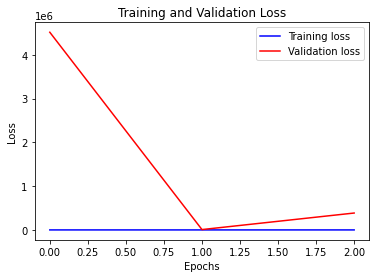

In [16]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


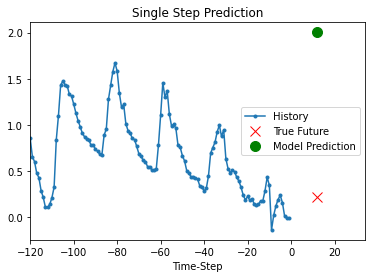

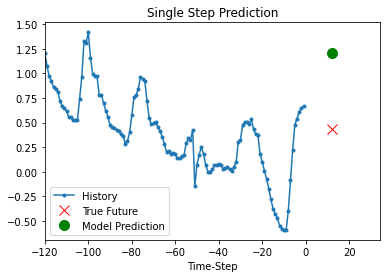

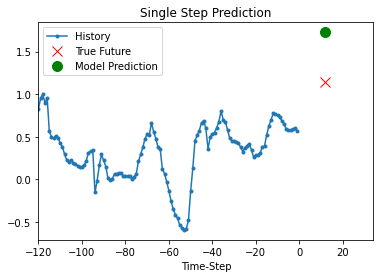

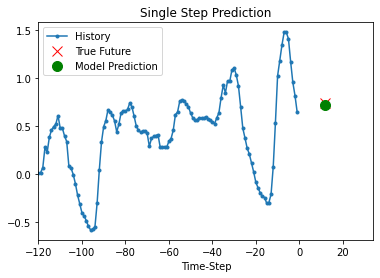

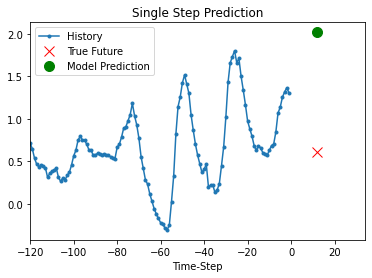

In [17]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )


In [15]:

#training_y = tensorflow.keras.utils.to_categorical(training_y)

#model.fit(training_x, training_y)

NameError: name 'tensorflow' is not defined